# Growing Decision Trees via ID3/C4.5 & Greedy Learning 


A from-scratch implementation of a growing decision trees ML algorithm for quick classification. We use entropy / 'information gain' as the metric for generating the decision rules. This notebook is a step-by-step walkthrough, with motivating graphs.


### General Structure of notebook:

* Introduce entropy function associated with the information gain metric that will be used to implement growing decision trees.
* Preliminary decision tree implementation
* Final decision tree implementation
* *Note:* Right now the decision tree implementation assumes a dataframe structure with:
    * the (desired) class label column having index 0 (first column)
    * an additional final (last indexed) column of aggregate counts
    
 There is nothing special about these requirements, and the code may eventually be rewritten to be a little more flexible (allow you to indicate the class label column at your disgression and let the counts column be located anywhere). As is discussed later, the class label column allows the dataset to be compressed and makes computations more efficient. Furthermore, I include a walkthrough of the relatively straightforward process of transforming a raw dataset into a compressed form with aggregate counts, and wrap it in a function which makes it straightforwards to apply. Also note this implementation is not optimized to run efficiently on large data.


### Example

An application of growing decision trees on a sample dataset. I've included some sample datasets to test the implementation on.

In [429]:
### Example Bank Dataset

import pandas as pd

### Entering data as columns - pandas reads them as tuples though so they will have to be transformed
credit_ranking_data = ["Excellent","Excellent","Excellent","Excellent","Good","Good","Good","Good","Fair","Fair","Fair","Fair"]
age_data = ["< 30","< 30","> 60","> 60","30 - 60","30 - 60","< 30","< 30","> 60","30 - 60","< 30","< 30"]
gender_data = ["M","F","M","F","M","F","M","F","M","F","M","F"]
year_income_data = ["60k - 100k","> 100k","> 100k","60k - 100k","< 60k","60k - 100k","> 100k","60k - 100k","> 100k","60k - 100k","60k - 100k","< 60k"]
counts_data = [16,4,4,16,5,15,5,15,2,2,18,18]

ex_df = pd.DataFrame.from_records(data = [ credit_ranking_data, age_data, gender_data, year_income_data, counts_data])
### Transpose to put in proper form
ex_df = ex_df.T
### Add column labels
cols = ["credit-ranking","age","gender","year-income","count"]
ex_df.columns = cols
ex_df # just checking

,credit-ranking,age,gender,year-income,count
0,Excellent,< 30,M,60k - 100k,16
1,Excellent,< 30,F,> 100k,4
2,Excellent,> 60,M,> 100k,4
3,Excellent,> 60,F,60k - 100k,16
4,Good,30 - 60,M,< 60k,5
5,Good,30 - 60,F,60k - 100k,15
6,Good,< 30,M,> 100k,5
7,Good,< 30,F,60k - 100k,15
8,Fair,> 60,M,> 100k,2
9,Fair,30 - 60,F,60k - 100k,2


The bank-dataset table above is a useful illustration of the kind of formatting the algorithm I will write expects:

* The desired class-label column is the first column (this can be adjusted to be more flexible in the future)
* The last column is a count column (this  can be constructed without too much difficulty by using some aggregation functions on arbitrary unstructured datasets, and compresses the dataset to make the algorithm run more efficiently)

In the following, I walk through construction of the information purity heuristic which we use to grow the decision tree.


## Information Purity Measures

In [2]:
import math

# term from info function I
def p_logp(p): # scope --- p is proportion from 0 to 1
    if (p < 10**(-10)) | (p > 1 - 10**(-10)) :
        return 0
    else: return (-1) * p * math.log2(p)
    

We can use the "p_logp" function to compute the statistical information entropy (physical measure) that occurs from observing a proportion $p$ of observations:

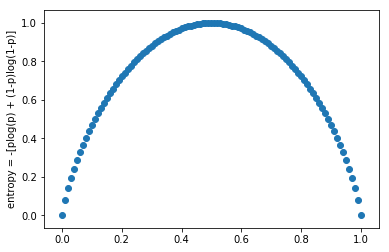

In [3]:
## EXAMPLE BASIC ENTROPY FUNCTION
granularity = 100
domain = [x/granularity for x in range(granularity+1)]
entropy_range = [ p_logp(p) + p_logp(1-p) for p in domain ]
# print(entropy_range)

import matplotlib.pyplot as plt
plt.scatter(domain,entropy_range)
plt.ylabel('entropy = -[plog(p) + (1-p)log(1-p)]')
plt.show()

In [4]:
# information measure

def info_measure(vector): ### NOTE: vector should be of counts, so all terms in it ≥ 0!! ADD CODE TO CHECK THIS LATER
    
#     if vector == [0]*len(vector):  return 0
    if sum(vector) == 0:  return 0
    return sum( [ p_logp( s/sum(vector) ) for s in vector ] )


## The Information measure $I(\mathbf{x}) = - \sum \left(\frac{x_i}{ \sum x_i } \right) \log_2 \left(\frac{x_i}{ \sum x_i } \right)$
generalizes this entropy measure to proportions drawn from higher-dimension source - ie, more than the two states corresponding to $p$ and $1-p$ (the interpretation of $\mathbf{x}$ is as a list of counts for the different states $i$). Thinking back to the basic entropy function we introduced, which came from our '$p \log_2 p$' function, if $p$ is the proportion $k/n$ then the basic entropy function was $I(\mathbf{x})$ where $\mathbf{x} = (k,n-k)$.

In general, this measures the amount of information required to classify a tuple $\mathbf{x}$ to $m$ classes (if the input $\mathbf{x}$ is an $m$-vector).

### An Example:

Consider: plotting the information measure over an input of datapoints $(x,y)$ uniformly sampled from the part of a 2D circle with $x,y \geq 0$ (since $x,y$ both represent counts (and the point $(x,y)$ then a configuration of counts in the system / data), then it makes sense although it is not necessary mathematically, to restrict our attention to a specific 'positive domain' subset of the circle.


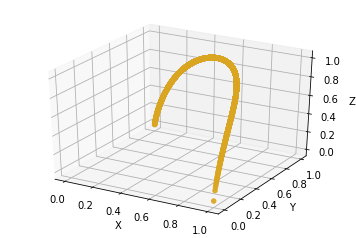

In [5]:
## EXAMPLE of the INFORMATION Measure on the input of a 2D circle

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import random

def circleplot(granularity,color=[random.random() for i in range(3)]):
    
#     granularity = 10000
    domain = [[x/granularity, (1-(x/granularity)**2)**0.5] for x in range(granularity+1)]
    entropy_range = [ info_measure(x) for x in domain ]
    # print(entropy_range)

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1, projection='3d')

    circ_points = [ x + [z] for x,z in zip(domain,entropy_range) ]

    xs = [x[0] for x in circ_points]
    ys = [x[1] for x in circ_points]
    zs = [x[2] for x in circ_points]

    ### different rectangular parametrizations of a 2d-circle
    ### we plot entropy associated with a particular configuration of points
    ax.scatter( xs,ys,zs , c=color)
    ### Can plot along all points on a circle - but don't have interpretations as negative counts
#     ax.scatter( xs,[-y for y in ys],zs , c=color )
#     ax.scatter( [-x for x in xs],ys,zs , c=color)
#     ax.scatter( [-x for x in xs],[-y for y in ys],zs , c=color)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # plt.scatter([x[0] for x in domain],entropy_range)
    # plt.scatter([x[1] for x in domain],entropy_range)
    # plt.ylabel('some numbers')
    plt.show()

circleplot(10000, 'goldenrod') # shortcut code

## Another example: 
Plot the information metric for classifying a mesh of 2D points $(x,y)$ over a rectangular region $x,y \in [0,1]$ (aka $[0,1] \times [0,1]$).

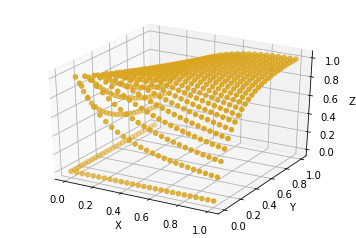

In [317]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

granularity = 25
domain = [[x/granularity, y/granularity] for x in range(granularity+1) for y in range(granularity+1)]
entropy_range = [ info_measure(x) for x in domain ]
# print(entropy_range)


fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')

rect_points = [ x + [z] for x,z in zip(domain,entropy_range) ]

xs = [x[0] for x in rect_points]
ys = [x[1] for x in rect_points]
zs = [x[2] for x in rect_points]

### we plot entropy associated with a particular configuration of points
ax.scatter( xs,ys,zs , c="goldenrod")

# ### plot circle for comparison

# #####

# granularity = 100
# domain = [[x/granularity, (1-(x/granularity)**2)**0.5] for x in range(granularity+1)]
# entropy_range = [ info_measure(x) for x in domain ]

# circ_points = [ x + [z] for x,z in zip(domain,entropy_range) ]

# xs = [x[0] for x in circ_points]
# ys = [x[1] for x in circ_points]
# zs = [x[2] for x in circ_points]

# ### different rectangular parametrizations of a 2d-circle
# ### we plot entropy associated with a particular configuration of points
# ax.scatter( xs,ys,zs , c='blue')
# # ax.scatter( xs,[-y for y in ys],zs , c='blue' )
# # ax.scatter( [-x for x in xs],ys,zs , c='blue')
# # ax.scatter( [-x for x in xs],[-y for y in ys],zs , c='blue')

# #####

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# plt.scatter([x[0] for x in domain],entropy_range)
# plt.scatter([x[1] for x in domain],entropy_range)
# plt.ylabel('some numbers')
plt.show()

Comparison of Plots: [TBD]

## Entropy Function

Next, we want to use the information measure to formally define an entropy function for attributes of a dataset, which is based off a weighted sum of the aggregate information measures for a given configuration of data: If the attribute $A$ with values $\{ a_1 , \dots , a_\nu \}$ partitions the dataset into subsets $\{S_1, \dots , S_\nu\}$, and $S_j$ contains $s_{ij}$ samples of a given class class $C_i$, then the entropy associated with $A$ is 

$$
E ( A ) = \sum_{j=1} ^\nu \frac{ s_{1j} + \cdots + s_{mj} }{\sum_{ij} s_{ij}} I(s_{1j} , \dots , s_{mj})
$$

Some observations –– from intuition (and by studying its defining equation) we can see that $I ( \mathbf{x} )$ tends to be maximized along the line $x_1 = x_2 = \cdots = x_m$, and hence so does the entropy function. As the interpretation of these $x_i$ was as counts for different states $i$, this means roughly speaking that we maximize entropy when the counts are similar and minimize it when they are very different. The metric we will use to grow the decision tree is information purity, or information gain, which increases as entropy decreases. So, we will maximize this when we split over branches where the counts tend to be most dissimilar. This all makes sense too, as if the counts are very dissimilar, than intuitively it is easier to predict a class label based on the counts while if they are similar, it is more difficult to decide what an appropriate class label should be.

In [7]:
# entropy cost associated with an attribute
# ASSUME: last column of input dataset is 'count' associated with particular outcome
# ASSUME: first column is class label

def entropy(dataset, attribute, debug_flag=False):
    label = dataset.iloc[:,0] # 1st column class label
    total_counts = sum(dataset['count'])  # REPLACE 'count' eventually
    total_entropy = 0
    
    for value in set(dataset[attribute]):
        if debug_flag: print(attribute, value) #debugging
        sub_data = dataset.loc[dataset[attribute] == value]
        if debug_flag: print(sub_data) #debugging
        
        label_counts = []
        for label_value in set(label):
            # pick out rows from sub data with desired label value
            sub_sub_data = sub_data.loc[sub_data.iloc[:,0] == label_value] 
            label_counts.append(sum(sub_sub_data['count']))  # REPLACE 'count' eventually

#         if debug_flag: print(label_counts) #debugging
        if debug_flag: print(str(sum(label_counts)) + '/' + str(total_counts) + ' * I(' + str(label_counts) + ')') #debugging


        total_entropy += (sum(label_counts)/total_counts) * info_measure(label_counts)
    if debug_flag: print('*'*50)
    return total_entropy


In [8]:
### ENTROPY on example dataset

print(ex_df)

print()
print('*' * 50)
print()

## Possible attributes to compute entropy on:
## Remove class label and count columns from consideration
possible_attributes = list(ex_df.columns)
possible_attributes = [possible_attributes[i] for i in range(1,len(possible_attributes)-1)] 

print((possible_attributes[0], 'entropy: ' 
       + str(entropy(ex_df, possible_attributes[0], debug_flag = False))))

   credit-ranking      age gender year-income count
0       Excellent     < 30      M  60k - 100k    16
1       Excellent     < 30      F      > 100k     4
2       Excellent     > 60      M      > 100k     4
3       Excellent     > 60      F  60k - 100k    16
4            Good  30 - 60      M       < 60k     5
5            Good  30 - 60      F  60k - 100k    15
6            Good     < 30      M      > 100k     5
7            Good     < 30      F  60k - 100k    15
8            Fair     > 60      M      > 100k     2
9            Fair  30 - 60      F  60k - 100k     2
10           Fair     < 30      M  60k - 100k    18
11           Fair     < 30      F       < 60k    18

**************************************************

('age', 'entropy: 1.1265494549903445')


In [9]:
# Define Information Gain Criteria 
# equivalent to minimizing entropy but has a nice interpretation

def info_gain(dataset, attribute, debug_flag = False):
    
    #get label counts
    label = dataset.iloc[:,0] # assume it's first column for now
    label_counts = []
    
    for label_value in set(label):
        # pick out rows from dataset with desired label value
        sub_data = dataset.loc[dataset.iloc[:,0] == label_value] 
        label_counts.append(sum(sub_data['count']))  # REPLACE 'count' eventually

    if debug_flag: 
        print('I(...):', label_counts) #debugging
        print('*'*50) #debugging
    
    I = info_measure(label_counts)
    return I - entropy(dataset, attribute, debug_flag)


In [315]:
info_gain(ex_df,possible_attributes[2],debug_flag=True) # debug flag displays info_measure coefficients

I(...): [40, 40, 40]
**************************************************
year-income < 60k
   credit-ranking      age gender year-income count
4            Good  30 - 60      M       < 60k     5
11           Fair     < 30      F       < 60k    18
23/120 * I([5, 18, 0])
year-income > 100k
  credit-ranking   age gender year-income count
1      Excellent  < 30      F      > 100k     4
2      Excellent  > 60      M      > 100k     4
6           Good  < 30      M      > 100k     5
8           Fair  > 60      M      > 100k     2
15/120 * I([5, 2, 8])
year-income 60k - 100k
   credit-ranking      age gender year-income count
0       Excellent     < 30      M  60k - 100k    16
3       Excellent     > 60      F  60k - 100k    16
5            Good  30 - 60      F  60k - 100k    15
7            Good     < 30      F  60k - 100k    15
9            Fair  30 - 60      F  60k - 100k     2
10           Fair     < 30      M  60k - 100k    18
82/120 * I([30, 20, 32])
**************************************

0.20128468771045682

In [316]:
for attribute in possible_attributes:
    print(( attribute, 'entropy: ' + str(entropy(ex_df,attribute)), 'gain: ' + str(info_gain(ex_df,attribute)) ))
# information gained by branching on attribute A

('age', 'entropy: 1.1265494549903445', 'gain: 0.45841304573081154')
('gender', 'entropy: 1.5421864522230475', 'gain: 0.042776048498108565')
('year-income', 'entropy: 1.3836778130106993', 'gain: 0.20128468771045682')


## Growing Decision Trees:

Now that we have a properly defined information gain metric for a given attribute of a dataset, we're prepared to use this to implement growing a decision tree such that it maximizes local information gain on each attribute, at each step. 

Note: We should be careful to avoid overgrowing the tree (various methods not yet implemented) as well as to look into methods to post/pre prune a tree in order to avoid over-fitting the decision tree model on the data. For example, we could implement a $k$-fold cross validation method to grow $k$ different trees on train/test folds and compare the overall accuracy obtained, and try boosting to improve on the accuracy of the model. 

### Printing decision trees

Here is a first pass at a growing-decision-tree algorithm, that prints generated decision rules as well as debugging info. It will automatically grow decisions to full length (use every attribute) even when not necessary. This overgrowing will be optimized for the proper algorithm.

In [410]:
#### GROWING DECISION TREES:

def print_decision_tree(dataset, condition_text='', debug_flag = False): # condition_text used to pass conditions down the desicion tree (for printing)
    
    if debug_flag: print(dataset) # for debugging
    
    columns = list(dataset.columns)
#     label = columns[0]
#     counts = columns[len(columns)]
    
    # get possible attributes for branching
    possible_attributes = columns
    possible_attributes = [possible_attributes[i] for i in range(1,len(possible_attributes)-1)] # remove first entry (class label) and last (count)

    if len(possible_attributes) > 0: ### can still keep branching
        
        # maximize info gain on possible attributes
        info_gains = [info_gain(dataset, attribute) for attribute in possible_attributes]
        # as first index for label wasn't included in info_gains, we do +1 to get the correct index
        branching_index = info_gains.index(max(info_gains)) + 1 

        new_condition = 'branch on ' + str(columns[branching_index]) # the new attribute to branch on
#         print( new_condition ) # this info is printed as 'rule' below

        branching_attribute = dataset.iloc[:,branching_index]
        for attribute_value in set(branching_attribute):
            sub_dataset = dataset.loc[ dataset.iloc[:,branching_index] == attribute_value]
            sub_dataset = sub_dataset.drop(columns[branching_index], axis=1)
            
            rule = condition_text + ' ' + new_condition + ': ' + str(attribute_value)
            print(rule)
#             print(attribute_value)
            # iterate
            print_decision_tree( sub_dataset, rule, debug_flag )
        
    else: # no more attributes to split on, so take majority vote to decide what the correct label is
        
        votes = []
        for outcome in set(dataset.iloc[:,0]):
            sub_dataset = dataset.loc[dataset.iloc[:,0] == outcome]
            votes.append( [outcome, sum(sub_dataset['count'])] )  # REPLACE 'count' eventually
        
        temp = [x[1] for x in votes]
        decision_index = temp.index(max(temp))
        decision = votes[decision_index][0]
        
        print( 'final decision: ' + str(decision))
        print('*'*50)
    
    return # returns null-type

In [411]:
# Example

ex_df

,credit-ranking,age,gender,year-income,count
0,Excellent,< 30,M,60k - 100k,16
1,Excellent,< 30,F,> 100k,4
2,Excellent,> 60,M,> 100k,4
3,Excellent,> 60,F,60k - 100k,16
4,Good,30 - 60,M,< 60k,5
5,Good,30 - 60,F,60k - 100k,15
6,Good,< 30,M,> 100k,5
7,Good,< 30,F,60k - 100k,15
8,Fair,> 60,M,> 100k,2
9,Fair,30 - 60,F,60k - 100k,2


In [412]:
print_decision_tree(ex_df)


 branch on age: 30 - 60
 branch on age: 30 - 60 branch on gender: F
 branch on age: 30 - 60 branch on gender: F branch on year-income: 60k - 100k
final decision: Good
**************************************************
 branch on age: 30 - 60 branch on gender: M
 branch on age: 30 - 60 branch on gender: M branch on year-income: < 60k
final decision: Good
**************************************************
 branch on age: < 30
 branch on age: < 30 branch on year-income: < 60k
 branch on age: < 30 branch on year-income: < 60k branch on gender: F
final decision: Fair
**************************************************
 branch on age: < 30 branch on year-income: > 100k
 branch on age: < 30 branch on year-income: > 100k branch on gender: F
final decision: Excellent
**************************************************
 branch on age: < 30 branch on year-income: > 100k branch on gender: M
final decision: Good
**************************************************
 branch on age: < 30 branch on year-in

### Evolving the function slightly

After the first pass, we're ready to amend some flaws. Right now I have set up a decision tree builder using recursion. It outputs a two item list –– the first is a list of 'verbose' decision branches (as strings) and the second is a condensed form of the decision tree as lists. Probably eventually I will rewrite the second form to either remove it entirely, or make its output more amenable for direct analysis. 

In [413]:
### Initial Pass

# still need to alter algorithm to prevent 'overgrowing' the tree when unnecessary

def decision_tree(dataset, condition_text='', decision_rules_human_readable=[], decision_rules_as_list=[]):     
    
    columns = list(dataset.columns)
    
    possible_attributes = columns
    possible_attributes = [possible_attributes[i] for i in range(1,len(possible_attributes)-1)] # remove first entry (class label) and last (count)

    
    ## len(list(set(dataset.iloc[:,0]))) == '#' of out omes in class label
    boolean = not ( len(set(dataset.iloc[:,0])) == 1 ) # ie there are more than 1 class labels in the data still
    if (len(possible_attributes) > 0 & boolean): ### can keep branching
        
        # maximize info gain on possible attributes
        info_gains = [info_gain(dataset, attribute) for attribute in possible_attributes]
        branching_index = info_gains.index(max(info_gains)) + 1 # as first index for label wasn't included in info_gains

        new_condition = str(columns[branching_index])

        branching_attribute = dataset.iloc[:,branching_index]
        for attribute_value in set(branching_attribute):
            sub_dataset = dataset.loc[ dataset.iloc[:,branching_index] == attribute_value]
            sub_dataset = sub_dataset.drop(columns[branching_index], axis=1)
            
            rule = condition_text + '%.%' + new_condition + '%.%' + str(attribute_value)
            
            decision_rules_as_list += [[ columns[branching_index], attribute_value ]] 
        
            # If it's a 'complete decision rule' add it to the list
            if len(possible_attributes) == 1: decision_rules_human_readable.append( [rule], )

            decision_tree( sub_dataset, rule, decision_rules_human_readable, decision_rules_as_list )
                
    else: # no more attributes to split on, assign label via majority vote
        
        votes = []
        for outcome in set(dataset.iloc[:,0]):
            sub_dataset = dataset.loc[dataset.iloc[:,0] == outcome]
            votes.append( [outcome, sum(sub_dataset['count'])] )  # REPLACE 'count' eventually
        
        temp = [x[1] for x in votes]
        decision_index = temp.index(max(temp))
        decision = votes[decision_index][0]
        
        decision_rules_human_readable += [' final decision:' + str(decision)]
        decision_rules_as_list += [[columns[0], decision]]
    
    return [decision_rules_human_readable, decision_rules_as_list]

Let's test building decision trees on our example dataset:

In [414]:
trees = decision_tree(ex_df)

trees[0]

[['%.%age%.%30 - 60%.%gender%.%F%.%year-income%.%60k - 100k'],
 ' final decision:Good',
 ['%.%age%.%30 - 60%.%gender%.%M%.%year-income%.%< 60k'],
 ' final decision:Good',
 ['%.%age%.%< 30%.%year-income%.%< 60k%.%gender%.%F'],
 ' final decision:Fair',
 ['%.%age%.%< 30%.%year-income%.%> 100k%.%gender%.%F'],
 ' final decision:Excellent',
 ['%.%age%.%< 30%.%year-income%.%> 100k%.%gender%.%M'],
 ' final decision:Good',
 ['%.%age%.%< 30%.%year-income%.%60k - 100k%.%gender%.%F'],
 ' final decision:Good',
 ['%.%age%.%< 30%.%year-income%.%60k - 100k%.%gender%.%M'],
 ' final decision:Fair',
 ['%.%age%.%> 60%.%gender%.%F%.%year-income%.%60k - 100k'],
 ' final decision:Excellent',
 ['%.%age%.%> 60%.%gender%.%M%.%year-income%.%> 100k'],
 ' final decision:Excellent']

### Breakdown and Accuracy

I wrote a quick tool that uses the 'verbose' stem of the decision tree builder to compute the accuracy of the decision rule numerically, as well as in fraction form (so that we can easily skim through effect size). I may rewrite it slightly in the future in order to either:

* perhaps use the list form output of the decision tree
* directly leave in effect size so that output can be sorted for highest accuracy *and* effect size simultaneously

In [415]:
def accuracy(dataset, label):
        
    correct_counts = sum( dataset.loc[ dataset.iloc[:, 0] == label ]['count'] )
    total_counts = sum( dataset['count'] )
#     if total_counts==0: print(dataset)
#     print(correct_counts, total_counts)
    acc = correct_counts / total_counts
    
    return (acc, str(correct_counts) + '/' + str(total_counts))

def analyze(dataset, decision_rules_list, importance_filter=False):
    
    result = []
    
    columns = list(dataset.columns)
    
#     print('length of decision list is ' + str(len(decision_rules_list)))
    
    for i in range( int(len(decision_rules_list) / 2) ):
        parsed = [x.split('%.%') for x in decision_rules_list[2*i]]
        # get attributes from decision rule branch
        # get subdataset satisfying parsed rules
        
        conditions = parsed[0][1:]        #throw away 0th term = a space
        
        subdataset = dataset
        for j in range( int(len(conditions)/2) ): # -1 to prevent inex to go 1 iteration too many (and pass in empty arg)
            index = columns.index(conditions[2*j])
            
#             print(i,j)
#             print(conditions)
#             print(columns[index], conditions[2*j+1])
            
            subdataset = subdataset.loc[ subdataset.iloc[:,index] == conditions[2*j + 1]]
        
#         print('8'*20)
        
        decision = decision_rules_list[2*i+1].split(':')[1]
        
#         print(decision) 
#         print(subdataset)
        
        result.append(accuracy(subdataset, decision))
        
        i = i + 2 # new rule starts every two entries
    
    trees_and_accuracy = [ [decision_rules_list[2*i] + [decision_rules_list[2*i+1]] , result[i]] for i in range(len(result)) ]
    
    # sorts by accuracy, decreasing. set importance threshold at say .1% of database size?
    if importance_filter: 
        temp = sorted(trees_and_accuracy, key=lambda x: x[1], reverse = True)
        final_info = [x for x in temp if (int(x[1][1][0]) > 15) ]
    else: final_info = sorted(trees_and_accuracy, key=lambda x: x[1], reverse = True) 
        
    return final_info
    
    
### Outputs list of decision branches + accuracy
        

In [416]:
analyze(ex_df, trees[0])

[[['%.%age%.%30 - 60%.%gender%.%M%.%year-income%.%< 60k',
   ' final decision:Good'],
  (1.0, '5/5')],
 [['%.%age%.%< 30%.%year-income%.%> 100k%.%gender%.%M',
   ' final decision:Good'],
  (1.0, '5/5')],
 [['%.%age%.%< 30%.%year-income%.%> 100k%.%gender%.%F',
   ' final decision:Excellent'],
  (1.0, '4/4')],
 [['%.%age%.%< 30%.%year-income%.%< 60k%.%gender%.%F', ' final decision:Fair'],
  (1.0, '18/18')],
 [['%.%age%.%> 60%.%gender%.%F%.%year-income%.%60k - 100k',
   ' final decision:Excellent'],
  (1.0, '16/16')],
 [['%.%age%.%< 30%.%year-income%.%60k - 100k%.%gender%.%F',
   ' final decision:Good'],
  (1.0, '15/15')],
 [['%.%age%.%30 - 60%.%gender%.%F%.%year-income%.%60k - 100k',
   ' final decision:Good'],
  (0.8823529411764706, '15/17')],
 [['%.%age%.%> 60%.%gender%.%M%.%year-income%.%> 100k',
   ' final decision:Excellent'],
  (0.6666666666666666, '4/6')],
 [['%.%age%.%< 30%.%year-income%.%60k - 100k%.%gender%.%M',
   ' final decision:Fair'],
  (0.5294117647058824, '18/34')]]

# A Few More Examples

Let's see the algorithm in practice on a few more datasets and extend it beyond the 'toy' dataset ex_df we've used so far.

## 2. Working with a raw dataset from scratch

I first generate a (skewed) dataset using the label-pools from ex_df, and put it into the standard form my decision tree algorithm utilizes before building decision trees and analyzing the results:

In [424]:
### Entering data as columns - pandas reads them as tuples though so they will have to be transformed

credit_ranking_data = ["Excellent","Good","Fair"]
age_data = ["> 60","30 - 60","< 30"]
gender_data = ["M","F"]
year_income_data = ["> 100k","60k - 100k","< 60k"]
# counts_data # I will build the counts

aggregate_attributes = [credit_ranking_data, age_data, gender_data, year_income_data]

### simulate_data:

import random

n = 10000
data = []
for i in range(n):
    
    # to make it more interesting / realistic, I am going to skew it slightly
    if i % 15 == 0: 
        data.append(["Excellent", 
                     random.choice(age_data[0:2]), 
                     "F", 
                     random.choice(year_income_data[1:2])])
    else: data.append( [random.choice(x) for x in aggregate_attributes] )

df = pd.DataFrame.from_records(data)

# ### Add column labels

cols = ["credit-ranking","age","gender","year-income"]#,"count"]
df.columns = cols
df.head() # just checking





,credit-ranking,age,gender,year-income
0,Excellent,30 - 60,F,60k - 100k
1,Good,< 30,M,60k - 100k
2,Good,30 - 60,M,60k - 100k
3,Good,< 30,F,> 100k
4,Excellent,30 - 60,M,> 100k


### Compressing the raw dataset 

I'm going to build the counts column and shrink the dataset in size. This helps make the algorithm scale since we don't have to access the entire dataset.

In [425]:
compressed_df = df[ [not x for x in df.duplicated()] ]

# following is good for sorting but runs into a copy-setting warning, so I've just left it out for the moment
# compressed_df["credit-ranking"] = pd.Categorical(compressed_df['credit-ranking'], ["Excellent","Good","Fair"])

# sorts by variable, in order
compressed_df = compressed_df.sort_values(["credit-ranking", 'age', 'gender'])

print('length:', len(compressed_df))

compressed_df.head()

length: 54


,credit-ranking,age,gender,year-income
0,Excellent,30 - 60,F,60k - 100k
33,Excellent,30 - 60,F,< 60k
68,Excellent,30 - 60,F,> 100k
4,Excellent,30 - 60,M,> 100k
8,Excellent,30 - 60,M,< 60k


In [426]:
## Add counts:
# reminder about cols = columns

counts = []
for index, row in compressed_df.iterrows():
    
    #count
    sub_df = df
    for i in range(len(cols)):
        sub_df = sub_df.loc[ df[cols[i]] == row[i] ] 
        
    count = sum( sub_df.duplicated() )
    counts.append(count + 1) # +1 since undercounting duplicates by 1 (removes the original comparison)
    
compressed_df['count'] = counts

print('total counts:' , sum(compressed_df['count'])) # had better sum to the original 10000

compressed_df[0:15] # first 15 terms



total counts: 10000


,credit-ranking,age,gender,year-income,count
0,Excellent,30 - 60,F,60k - 100k,507
33,Excellent,30 - 60,F,< 60k,185
68,Excellent,30 - 60,F,> 100k,197
4,Excellent,30 - 60,M,> 100k,168
8,Excellent,30 - 60,M,< 60k,185
26,Excellent,30 - 60,M,60k - 100k,185
74,Excellent,< 30,F,60k - 100k,180
143,Excellent,< 30,F,< 60k,185
146,Excellent,< 30,F,> 100k,176
29,Excellent,< 30,M,> 100k,174


In [431]:
tree = decision_tree(compressed_df)

# tree[0] # stores the verbose decision trees

analyze(compressed_df, tree[0])[0:10]



[[['%.%gender%.%F%.%age%.%30 - 60%.%year-income%.%60k - 100k',
   ' final decision:Excellent'],
  (0.61084337349397588, '507/830')],
 [['%.%gender%.%F%.%age%.%30 - 60%.%year-income%.%60k - 100k',
   ' final decision:Excellent'],
  (0.61084337349397588, '507/830')],
 [['%.%gender%.%F%.%age%.%30 - 60%.%year-income%.%60k - 100k',
   ' final decision:Excellent'],
  (0.61084337349397588, '507/830')],
 [['%.%gender%.%F%.%age%.%30 - 60%.%year-income%.%60k - 100k',
   ' final decision:Excellent'],
  (0.61084337349397588, '507/830')],
 [['%.%year-income%.%60k - 100k%.%gender%.%F%.%age%.%30 - 60',
   ' final decision:Excellent'],
  (0.61084337349397588, '507/830')],
 [['%.%year-income%.%60k - 100k%.%gender%.%F%.%age%.%30 - 60',
   ' final decision:Excellent'],
  (0.61084337349397588, '507/830')],
 [['%.%age%.%> 60%.%gender%.%F%.%year-income%.%60k - 100k',
   ' final decision:Excellent'],
  (0.60462287104622869, '497/822')],
 [['%.%gender%.%F%.%age%.%> 60%.%year-income%.%60k - 100k',
   ' final d

Some interesting (and relatively weak) results --- unsurprising considering how much of the data was randomly generated. Lets wrap the compression procedure above in a function we can reuse:

In [442]:
def structure_data(dataframe):
    
    ### 
    # Assumes a pandas dataframe
    
    ### Compress dataframe
    
    compressed_df = dataframe[ [not x for x in dataframe.duplicated()] ]

    columns = list(dataframe.columns)
    # sorts by variable, in order
    compressed_df = compressed_df.sort_values(columns)

#     # debug
#     print('length:', len(compressed_df))
#     compressed_df.head()
    
    ### Add counts:

    counts = []
    for index, row in compressed_df.iterrows():
    
        #count
        sub_dataframe = dataframe
        for i in range(len(columns)):
            sub_dataframe = sub_dataframe.loc[ dataframe[columns[i]] == row[i] ] 

        count = sum( sub_dataframe.duplicated() )
        counts.append(count + 1) # +1 since undercounting duplicates by 1 (removes the original comparison)
    
    compressed_df['count'] = counts

    # debug
    print('total counts:' , sum(compressed_df['count']), 'dataset length:' , len(dataframe))

    return compressed_df


## 3. Working with a (slightly) larger dataset

The Food Mart dataset contains approximately 2000 transactions containing subsets of 100 different items - a simplified version of a small market transaction database TDB. Each row is a transaction, and a 1 in the tuple indicates the item was purchased, a 0 indicates it wasn't. One feature to notice in this dataset is the sparseness of the TDB --- most transactions will only contain a few of the 100 various products.

In [443]:
# Example 3

Food_Mart = pd.read_excel('FoodMart.xls')

In [466]:
print(Food_Mart.columns)

Food_Mart.head()

Index(['Acetominifen', 'Anchovies', 'Aspirin', 'Auto Magazines', 'Bagels',
       'Batteries', 'Beer', 'Bologna', 'Candles', 'Canned Fruit',
       'Canned Vegetables', 'Cereal', 'Cheese', 'Chips', 'Chocolate',
       'Chocolate Candy', 'Clams', 'Cleaners', 'Coffee', 'Cold Remedies',
       'Computer Magazines', 'Conditioner', 'Cookies', 'Cooking Oil',
       'Cottage Cheese', 'Crackers', 'Deli Meats', 'Deli Salads',
       'Deodorizers', 'Dips', 'Donuts', 'Dried Fruit', 'Dried Meat', 'Eggs',
       'Fashion Magazines', 'Flavored Drinks', 'French Fries', 'Fresh Chicken',
       'Fresh Fish', 'Frozen Chicken', 'Frozen Vegetables', 'Gum', 'Hamburger',
       'Hard Candy', 'Home Magazines', 'Hot Dogs', 'Ibuprofen', 'Ice Cream',
       'Jam', 'Jelly', 'Juice', 'Lightbulbs', 'Maps', 'Milk', 'Mouthwash',
       'Muffins', 'Nasal Sprays', 'Nuts', 'Oysters', 'Pancake Mix', 'Pancakes',
       'Paper Dishes', 'Paper Wipes', 'Pasta', 'Peanut Butter',
       'Personal Hygiene', 'Pizza', 'Plastic U

,Acetominifen,Anchovies,Aspirin,Auto Magazines,Bagels,Batteries,Beer,Bologna,Candles,Canned Fruit,...,Sunglasses,Tofu,Toilet Brushes,Tools,Toothbrushes,Tuna,TV Dinner,Waffles,Wine,Yogurt
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


It is difficult to run the unoptimized compressor on the full dataset, so instead let us restrict our attention to a subset:


In [476]:
columns_subset = list(Food_Mart.columns)[35:65]

small_df = pd.DataFrame(data = [ Food_Mart[x] for x in columns_subset ]).T
#         [
#          Food_Mart['Cooking Oil'], Food_Mart['Eggs'],
#          Food_Mart['Frozen Chicken'], Food_Mart['Frozen Vegetables'],
#          Food_Mart['Pancake Mix'], Food_Mart['Sauces'], 
#          Food_Mart['Pot Scrubbers'], Food_Mart['Soup'], 
#          Food_Mart['Sour Cream'], Food_Mart['Spices'], 
#          Food_Mart['Sugar']]).T # T for transpose

df = structure_data(small_df)

df.head()

total counts: 2127 dataset length: 2127


,Flavored Drinks,French Fries,Fresh Chicken,Fresh Fish,Frozen Chicken,Frozen Vegetables,Gum,Hamburger,Hard Candy,Home Magazines,...,Nasal Sprays,Nuts,Oysters,Pancake Mix,Pancakes,Paper Dishes,Paper Wipes,Pasta,Peanut Butter,count
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,620
121,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,25
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,28
499,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,3
110,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,58


Let's suppose we also want to predict whether French Fries are purchased –– we can reorder the columns as well:

In [479]:
### Reorder 

old_cols = df.columns.tolist()

index_salads = old_cols.index('French Fries')
cols = [old_cols[index_salads]] + [ old_cols[i] for i in range(len(old_cols)) if i != index_salads ]

fm_df = df[cols]

fm_df.head()

,French Fries,Flavored Drinks,Fresh Chicken,Fresh Fish,Frozen Chicken,Frozen Vegetables,Gum,Hamburger,Hard Candy,Home Magazines,...,Nasal Sprays,Nuts,Oysters,Pancake Mix,Pancakes,Paper Dishes,Paper Wipes,Pasta,Peanut Butter,count
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,620
121,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,25
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,28
499,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,3
110,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,58


In [484]:
fm_tree = decision_tree(fm_df,'',[],[]) # have to overwrite stored values from previous use


In [488]:
fm_tree[0][0:5]

[['%.%Frozen Chicken%.%0%.%Jam%.%0%.%Oysters%.%0%.%Fresh Fish%.%0%.%Pancake Mix%.%0%.%Lightbulbs%.%0%.%Nuts%.%0%.%Fresh Chicken%.%0%.%Pancakes%.%0%.%Milk%.%0%.%Gum%.%0%.%Paper Dishes%.%0%.%Peanut Butter%.%0%.%Jelly%.%0%.%Hamburger%.%0%.%Ice Cream%.%0%.%Hot Dogs%.%0%.%Muffins%.%0%.%Juice%.%0%.%Home Magazines%.%0%.%Maps%.%0%.%Pasta%.%0%.%Flavored Drinks%.%0%.%Nasal Sprays%.%0%.%Paper Wipes%.%0%.%Hard Candy%.%0%.%Mouthwash%.%0%.%Ibuprofen%.%0%.%Frozen Vegetables%.%0'],
 ' final decision:0',
 ['%.%Frozen Chicken%.%0%.%Jam%.%0%.%Oysters%.%0%.%Fresh Fish%.%0%.%Pancake Mix%.%0%.%Lightbulbs%.%0%.%Nuts%.%0%.%Fresh Chicken%.%0%.%Pancakes%.%0%.%Milk%.%0%.%Gum%.%0%.%Paper Dishes%.%0%.%Peanut Butter%.%0%.%Jelly%.%0%.%Hamburger%.%0%.%Ice Cream%.%0%.%Hot Dogs%.%0%.%Muffins%.%0%.%Juice%.%0%.%Home Magazines%.%0%.%Maps%.%0%.%Pasta%.%0%.%Flavored Drinks%.%0%.%Nasal Sprays%.%0%.%Paper Wipes%.%0%.%Hard Candy%.%0%.%Mouthwash%.%0%.%Ibuprofen%.%0%.%Frozen Vegetables%.%1'],
 ' final decision:0',
 ['%.%Frozen C

In [486]:
analyze(fm_df, fm_tree[0])[0:5]


/anaconda3/lib/python3.6/site-packages/pandas/core/ops.py:798: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(x, name)(y)


TypeError: invalid type comparison